https://www.kaggle.com/competitions/cisc873-dm-f22-a6

# **Problem Formulation**

**Problem:** We want to predict if a chemical compound (positive or negative) is against non-small cell lung cancer or not, and it is a classification problem that produces 0 or 1.

**Inputs:** nodes, and edges 

**Output:** Binary classify produce 1 or 0 according to a chemical compound (positive or negative) with cell lung cancer

**Function required:** Classification & Prediction

**Challenges:** 
1. Prepare nodes, labels, and links
2. Tokenize and convert data into integer numbers
3. Determine suitable model.
4. Unbalanced data
4. Use validation
5. Select optimal hyperparameters.
6. Find best accuracy.

**What is the impact?**
* If the model predicts the drug very well (it is affected by cancer or not)this means we will not wait to know how does the drug affect the cancer, as the model will tell you how does the drug affect the cancer before it is manufactured.

**What is the ideal solution?**
* The **Trial 3** is the best solution by using **GGNN**.
* Accuracy **0.85670** (public) **0.86969** (private) in kaggle


# **Trials**

## **Common Commands** in all models

**What is the experimental protocol used and how was it carried out?** \
1. Read Training and Testing Data 
2. Visualizing/Inspecting a Sample
2. Preprocessing 
5. Node Tokenizer
6. Tuning hyperparameters
7. Built model
8. Show plot
* I used the validation dataset method.

**How did we tune hyper-parameters in the template?**
- I tried to change the number of epochs, batch_size,max len of vocabulary, and hidden layer size. 
- I tried to change the layer that is used.
- Try and error

**What is the search space?**
 - Search space is specified by the tuning hyper parameters for each parameter.(Try and Error)

**what is the criteria to determine good/bad hyper-parameters?**

 - I define if hyper parameters are good or bad by loss function and performance metric, if the performance improves, that means the hyperparameters are good. If the performance is poor, it means the hyperparameters are bad.


**What preprocessing steps are used?**
1. Prepare nodes, labels, and links
2. Tokenize and convert data into integer numbers
3. Padding to tokenize
4. Determine the number of nodes in each sample
5. Generate multiple batches
6. Embedding

##### Import liberaries

In [ ]:
!pip install --quiet networkx
!pip install --quiet tf2_gnn

     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 1.2 MB 45.8 MB/s 
     |████████████████████████████████| 134 kB 51.4 MB/s 
     |████████████████████████████████| 346 kB 50.5 MB/s 
     |████████████████████████████████| 462 kB 50.1 MB/s 
     |████████████████████████████████| 178 kB 46.7 MB/s 
     |████████████████████████████████| 3.6 MB 41.8 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 85 kB 3.9 MB/s 
     |████████████████████████████████| 41 kB 520 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


In [ ]:
import os
from google.colab import drive
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
from tf2_gnn.layers.gnn import GNN, GNNInput
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
import math
import pandas as pd 
from sklearn.utils import resample

In [ ]:
#connect to my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Read Training and Testing data

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
  # Open and read the file that contains the nodes and the connection between the nodes
    with open(file, 'r') as rf:
        content = rf.read()
  # After each sample, there are dollar signs
  # so it will split between samples by these dollar signs
    samples = content.split('$$$$')
    
    def parse_sample(s):
      # split to take each line separately
        lines = s.splitlines()
        links = []   # empty array for links
        nodes = []    #empty array for nodes
        label = 0
        # this for loop will apply in each lines to extract the label of each sample
        # if get 1 in the line will assign 1 to label variable
        # if get -1 in the line will assign 0
        for l in lines:
          # strip used to remove all white space after and before the number( 1, -1)
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # if the line start with tab space it will split this line and put it in feature variable that contains nodes
            if l.startswith('    '):
                feature = l.split()
            # From this line will get fourth col that contains the name of nodes
                node = feature[3]
                nodes.append(node)
            # if the line start with 2 spaces it will split this line and put it in Ink variable that contains the links between nodes
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                  # We will take the first two numbers from each row(col)
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [ ]:
# Read all our training data by using read_csv, which takes the path of the file with the extension that I want to read.
training_set = read_sdf('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/train.sdf')


  0%|          | 0/25024 [00:00<?, ?it/s]

###### Imbalanced data

In [ ]:
# Display number of unique value that exist in training data to determine if there is a balance or imbalance data 
np.unique(np.array(training_set)[:,2],return_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(array([0, 1], dtype=object), array([23806,  1218]))

In [ ]:
X_train = pd.DataFrame(np.array(training_set)[:,:-1])
y_train = pd.DataFrame(np.array(training_set)[:,2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
X_train_res= X_train.copy()
X_train_res[2]=y_train.values
label_1=X_train_res[X_train_res[2]==1]
label_0=X_train_res[X_train_res[2]==0]
label_1_res = resample(label_1,
             replace=True,
             n_samples=23806,
             random_state=42)
concatinate_data=pd.concat([label_0,label_1_res])
print(concatinate_data.shape)

(47612, 3)


In [ ]:
training_set=concatinate_data.values.tolist()

In [ ]:
# Display number of unique value that exist in training data to determine if there is a balance or imbalance data 
np.unique(np.array(training_set)[:,2],return_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(array([0, 1], dtype=object), array([23806, 23806]))

In [ ]:
# split training data into training and validation data
training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=0)

In [ ]:
# Read all our testing data by using read_csv, which takes the path of the file with the extension that I want to read.
testing_set  = read_sdf('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

### Visualizing/Inspecting a Sample

In [ ]:
# rainbow function used to draw with colors
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
# The visualise function is used to visualise the data
def visualize(sample):
  # Graph is a collection of nodes along with identified pairs of nodes (node and links)
    G=nx.Graph()
    nodes = sample[0] # nodes
    edges = sample[1]  # connection between nodes(edges)
    
    labeldict={}  # Labels for the nodes are stored in an empty dictionary.
    node_color=[]   # list for node's color
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
    #drawing the graph with nodes and edges  
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

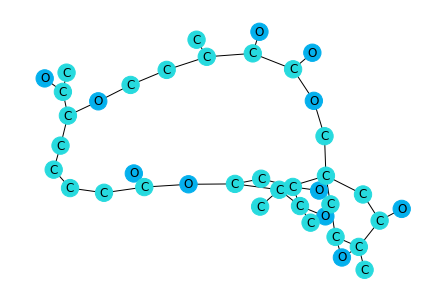

In [ ]:
# show one sample
plt.clf()
visualize(training_set[0])

In [ ]:
print('length of training_set:', len(training_set))
# training data have 3 values (nodes, labels, and links)
print('length of traiing_set[0]:', len(training_set[0]))
print('length of testing_set:', len(testing_set))
# training data have 3 values (nodes, labels(but all labels have value equal zerooo), and links)
print('length of testing_set[0]:', len(testing_set[0]))

length of training_set: 40470
length of traiing_set[0]: 3
length of testing_set: 12326
length of testing_set[0]: 3


## **Trials**

### **Trial 0**

* In this trial I will use:
 * I will use **unbalanced** data
 * Preprocessing
   * **max_vocab = 500**
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * **hidden_dim = 32** 
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using **epoch = 50** and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.70 and 0.73

#### Preprocessing

In [ ]:
max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[2 2 2 2 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 5 2 2 3 3 3 3 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 4 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 4 4 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
edges
[[  0   9]
 [  1  11]
 [  2  12]
 [  3  13]
 [  4   6]
 [  4   8]
 [  4   9]
 [  5   7]
 [  5   9]
 [  5  11]
 [  6  12]
 [  6  13]
 [  7   8]
 [  8  10]
 [ 10  14]
 [ 11  17]
 [ 12  18]
 [ 13  19]
 [ 14  15]
 [ 14  16]
 [ 15  20]
 [ 16  21]
 [ 20  22]
 [ 21  22]
 [ 22  23]
 [ 26  41]
 [ 27  34]
 [ 28  37]
 [ 29  32]
 [ 29  33]
 [ 29  34]
 [ 30  31]
 [ 30  34]
 [ 30  38]
 [ 31  33]
 [ 32  37]
 [ 33  35]
 [ 35  36]
 [ 36  39]
 [ 36  40]
 [ 37  44]
 [ 39  42]
 [ 40  43]
 [ 41  42]
 [ 41  43]
 [ 52  59]
 [ 52  70]
 [ 53  62]
 [ 53  71]
 [ 54  63]
 [ 54  73]
 [ 55  58]
 [ 55  61]
 [ 56  72]
 [ 56  74]
 [ 56  75]
 [ 57  58]
 [ 57  59]
 [ 57  62]
 [ 58  63]
 [ 59  60]
 [ 60  61]
 [ 60  66]
 [ 61  67]
 [ 62  64]
 [ 63  65]
 [ 64  65]
 [ 66  68]
 [ 67  69]
 [ 68  69]
 [ 70  

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyper parameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1856 - auc: 0.6800 - val_loss: 0.1829 - val_auc: 0.7384
Epoch 2/50
1330/1330 [==============================] - 26s 19ms/step - loss: 0.1863 - auc: 0.6794 - val_loss: 0.1809 - val_auc: 0.7438
Epoch 3/50
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1874 - auc: 0.6679 - val_loss: 0.1897 - val_auc: 0.7498
Epoch 4/50
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1866 - auc: 0.6713 - val_loss: 0.1871 - val_auc: 0.7383
Epoch 5/50
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1891 - auc: 0.6504 - val_loss: 0.1931 - val_auc: 0.6644
Epoch 6/50
1330/1330 [==============================] - 32s 24ms/step - loss: 0.1877 - auc: 0.6396 - val_loss: 0.2036 - val_auc: 0.5824
Epoch 7/50
1330/1330 [==============================] - 29s 22ms/step - loss: 0.1890 - auc: 0.6229 - val_loss: 0.1909 - val_auc: 0.7017
Epoch 8/50
1330/1330 [==========================

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.083676  , 0.03092517, 0.0200861 , ..., 0.01935035, 0.01927084,
       0.02188413], dtype=float32)

#### Display model

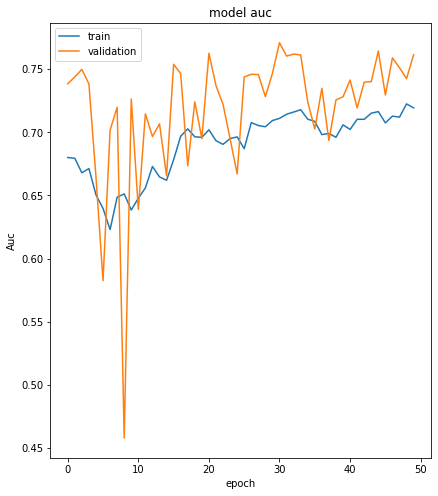

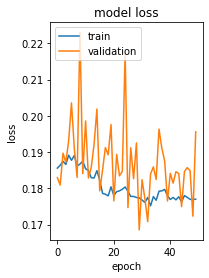

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.71578 \
From the diagram, the model can not learn very good and there is an overfitting, so I will try in the next trials to improve the accuracy

### **Trial 1**

* In this trial I will use:
 * I will use unbalanced data
 * Preprocessing
   * **I will change max_vocab = 550 , max_len = 150**
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * hidden_dim = 32
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.71 and 0.73

#### Preprocessing

In [ ]:
max_vocab = 550
max_len = 150

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 3 3 3
 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 2 2 2 2 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 2 2 2 2 2 2 2 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
edges
[[ 24   0]
 [  0  28]
 [  1  28]
 [  2   8]
 [  2  16]
 [  3   4]
 [  3  16]
 [  3  25]
 [  4  22]
 [  5   6]
 [  5   7]
 [  5  12]
 [  6   8]
 [  6  11]
 [  7   9]
 [  7  10]
 [  8  14]
 [  8  19]
 [  9  13]
 [  9  18]
 [  9  20]
 [ 10  14]
 [ 11  15]
 [ 12  17]
 [ 13  17]
 [ 13  21]
 [ 15  16]
 [ 15  22]
 [ 18  23]
 [ 21  24]
 [ 23  24]
 [ 25  26]
 [ 25  27]
 [ 26  29]
 [ 27  30]
 [ 28  32]
 [ 29  31]
 [ 30  31]
 [ 33  54]
 [ 34  35]
 [ 34  44]
 [ 34  45]
 [ 35  49]
 [ 36  44]
 [ 36  48]
 [ 37  38]
 [ 37  45]
 [ 38  50]
 [ 39  43]
 [ 39  47]
 [ 40  48]
 [ 41  49]
 [ 42  50]
 [ 43  51]
 [ 44  47]
 [ 45  46]
 [ 46  48]
 [ 46  50]
 [ 47  49]
 [ 51  52]
 [ 51  53]
 [ 52  55]
 [ 53  56]
 [ 54  55]
 [ 54  56]
 [ 66

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyper parameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

1330/1330 [==============================] - 30s 20ms/step - loss: 0.2266 - auc: 0.5014 - val_loss: 0.2102 - val_auc: 0.6077
Epoch 2/50
1330/1330 [==============================] - 26s 20ms/step - loss: 0.1972 - auc: 0.6166 - val_loss: 0.1874 - val_auc: 0.6895
Epoch 3/50
1330/1330 [==============================] - 26s 20ms/step - loss: 0.1914 - auc: 0.6499 - val_loss: 0.1876 - val_auc: 0.7260
Epoch 4/50
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1905 - auc: 0.6561 - val_loss: 0.1911 - val_auc: 0.7321
Epoch 5/50
1330/1330 [==============================] - 26s 20ms/step - loss: 0.1875 - auc: 0.6735 - val_loss: 0.1913 - val_auc: 0.7311
Epoch 6/50
1330/1330 [==============================] - 26s 20ms/step - loss: 0.1884 - auc: 0.6684 - val_loss: 0.1996 - val_auc: 0.7542
Epoch 7/50
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1875 - auc: 0.6741 - val_loss: 0.1802 - val_auc: 0.7488
Epoch 8/50
1330/1330 [==============================] - 26s

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.17143947, 0.02573386, 0.02440776, ..., 0.0203827 , 0.0337262 ,
       0.02491939], dtype=float32)

#### Display model

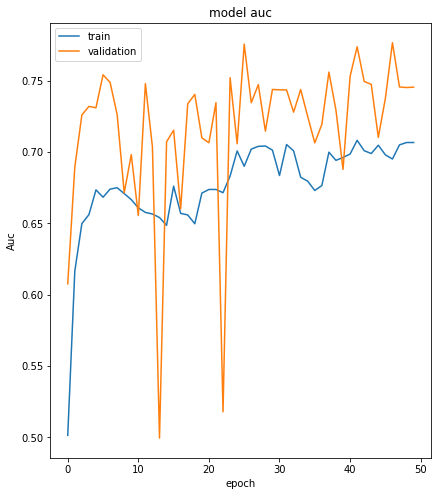

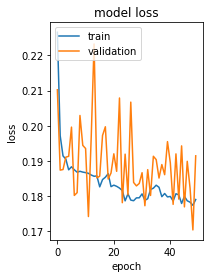

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.73371 \
From the diagram, the model can not learn very good and have overfitting greater than the previos trial, the data unbalanced, so I will try in the next trials to improve the accuracy and solve unbalanced data

### **Trial 2**

* In this trial I will use:
 * I will use **balanced** data
 * Preprocessing
   * max_vocab = 500 , max_len = 100
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * hidden_dim = 32
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.72 and 0.75

#### Preprocessing

In [ ]:
max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[5 4 2 2 2 2 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 5 2 2 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 6 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
edges
[[  0  13]
 [  1  18]
 [  1  19]
 [  2  11]
 [  2  17]
 [  3  17]
 [  4  22]
 [  4  28]
 [  5  23]
 [  5  29]
 [  6  10]
 [  6  17]
 [  6  20]
 [  7  15]
 [  7  19]
 [  8   9]
 [  8  19]
 [  9  25]
 [ 10  11]
 [ 10  16]
 [ 11  14]
 [ 12  13]
 [ 12  14]
 [ 12  15]
 [ 13  16]
 [ 15  18]
 [ 21  24]
 [ 21  25]
 [ 21  26]
 [ 22  23]
 [ 22  24]
 [ 23  27]
 [ 26  27]
 [ 43  58]
 [ 44  53]
 [ 45  54]
 [ 46  50]
 [ 46  54]
 [ 47  51]
 [ 48  49]
 [ 48  53]
 [ 50  51]
 [ 50  53]
 [ 51  52]
 [ 52  56]
 [ 52  57]
 [ 54  55]
 [ 55  61]
 [ 55  62]
 [ 56  59]
 [ 57  60]
 [ 58  59]
 [ 58  60]
 [ 61  63]
 [ 62  64]
 [ 63  65]
 [ 64  65]
 [ 86 108]
 

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyper parameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

2530/2530 [==============================] - 58s 22ms/step - loss: 0.6278 - auc: 0.7048 - val_loss: 0.6084 - val_auc: 0.7344
Epoch 2/50
2530/2530 [==============================] - 53s 21ms/step - loss: 0.5906 - auc: 0.7510 - val_loss: 0.6085 - val_auc: 0.7375
Epoch 3/50
2530/2530 [==============================] - 52s 21ms/step - loss: 0.5690 - auc: 0.7758 - val_loss: 0.5643 - val_auc: 0.7888
Epoch 4/50
2530/2530 [==============================] - 51s 20ms/step - loss: 0.5584 - auc: 0.7875 - val_loss: 0.5454 - val_auc: 0.7998
Epoch 5/50
2530/2530 [==============================] - 53s 21ms/step - loss: 0.5513 - auc: 0.7944 - val_loss: 0.5416 - val_auc: 0.8040
Epoch 6/50
2530/2530 [==============================] - 51s 20ms/step - loss: 0.5431 - auc: 0.8015 - val_loss: 0.5453 - val_auc: 0.8016
Epoch 7/50
2530/2530 [==============================] - 51s 20ms/step - loss: 0.5366 - auc: 0.8091 - val_loss: 0.5239 - val_auc: 0.8212
Epoch 8/50
2530/2530 [==============================] - 51s

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.830772  , 0.83625245, 0.01709474, ..., 0.21603425, 0.68570334,
       0.92305374], dtype=float32)

#### Display model

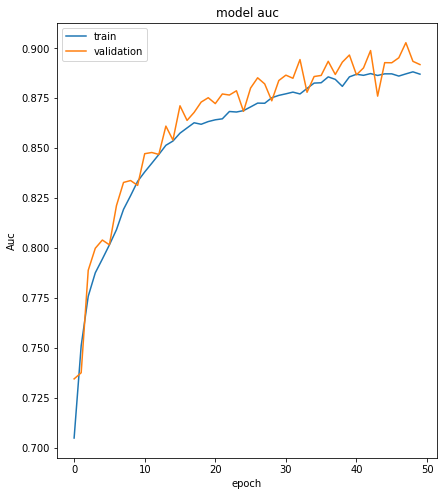

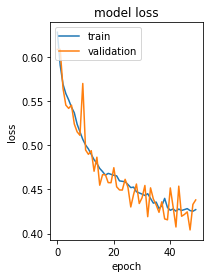

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.83610 \
From the diagram, the model learn better than last trials and the overfitting is reduce so I will try in the next trials to improve the accuracy more by using message_calculation_class and change preprocessing

### **Trial 3**

* In this trial I will use:
 * I will use **balanced** data
 * Preprocessing
   * **max_vocab = 450** , max_len = 100
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * **hidden_dim = 64**
            * **message_calculation_class = GGNN**
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.83 and 0.85

**GGNN (Gated Graph Neural Networks)**

It has four stages to produce the required output, and
it is suitable for non-sequential outputs. It uses a message-passing mechanism to compute graph states.\
Stages:
1. Start by examining the current neighbouring states.
2. Prepare the message that you want to send.
3. Summarized the message received
4. Enter the MSG into the GRU layers to transfer the message from the current state into the next state.

#### Preprocessing

In [ ]:
max_vocab = 450
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 2 2 2 3 3 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0   5]
 [  0  16]
 [  1   4]
 [  1  15]
 [  2  15]
 [  3  16]
 [  4   9]
 [  5   8]
 [  6   9]
 [  6  10]
 [  6  13]
 [  6  15]
 [  7   8]
 [  7  10]
 [  7  14]
 [  7  16]
 [  8  11]
 [  9  12]
 [ 11  13]
 [ 11  17]
 [ 12  14]
 [ 12  17]
 [ 50  67]
 [ 50  70]
 [ 67  51]
 [ 51  76]
 [ 68  52]
 [ 52  86]
 [ 53  71]
 [ 72  54]
 [ 55  73]
 [ 56  79]
 [ 57  80]
 [ 58  81]
 [ 59  86]
 [ 59  93]
 [ 60  88]
 [ 60  91]
 [ 61  85]
 [ 61  96]
 [ 62  88]
 [ 63  92]
 [ 63  98]
 [ 64  94]
 [ 65  95]
 [ 65  99]
 [ 66  95]
 [ 67  68]
 [ 67  72]
 [ 68  69]
 [ 69  70]
 [ 69  71]
 [ 70  73]

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyperparameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params['message_calculation_class'] = 'GGNN'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2530/2530 [==============================] - 76s 28ms/step - loss: 0.6010 - auc: 0.7391 - val_loss: 0.5927 - val_auc: 0.7960
Epoch 2/50
2530/2530 [==============================] - 76s 30ms/step - loss: 0.5377 - auc: 0.8063 - val_loss: 0.5085 - val_auc: 0.8312
Epoch 3/50
2530/2530 [==============================] - 64s 25ms/step - loss: 0.4961 - auc: 0.8398 - val_loss: 0.4761 - val_auc: 0.8548
Epoch 4/50
2530/2530 [==============================] - 64s 25ms/step - loss: 0.4570 - auc: 0.8670 - val_loss: 0.4544 - val_auc: 0.8841
Epoch 5/50
2530/2530 [==============================] - 64s 25ms/step - loss: 0.4149 - auc: 0.8920 - val_loss: 0.4092 - val_auc: 0.8966
Epoch 6/50
2530/2530 [==============================] - 66s 26ms/step - loss: 0.3880 - auc: 0.9061 - val_loss: 0.3777 - val_auc: 0.9116
Epoch 7/50
2530/2530 [==============================] - 64s 25ms/step - loss: 0.3579 - auc: 0.9201 - val_loss: 0.3603 - val_auc: 0.9235
Epoch 8/50
2530/2530 [==============================] - 63s

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([6.1297677e-02, 4.7582290e-03, 4.8891390e-03, ..., 1.7803769e-06,
       2.9569215e-05, 9.9874926e-01], dtype=float32)

#### Display model

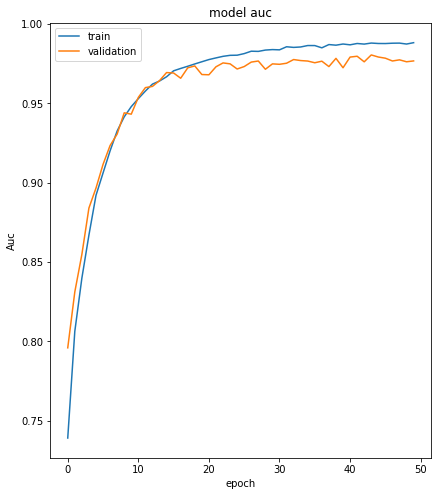

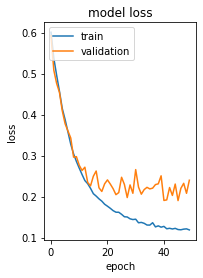

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.8567 \
From the diagram, the model learn better than last trials and the overfitting is very reduce and the accuracy very improved. In the next trial I will try to add more hyper parameters to improve accuracy more

### **Trial 4**

* In this trial I will use:
 * I will use **balanced** data
 * Preprocessing
   * **max_vocab = 450** , max_len = 100
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * **hidden_dim = 64**
            * **layer_input_dropout_rate = 0.2**
            * **use_inter_layer_layernorm = False**
            * **message_calculation_class = GGNN**
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.85 and 0.86

**GGNN (Gated Graph Neural Networks)**

It has four stages to produce the required output, and
it is suitable for non-sequential outputs.It uses a message-passing mechanism to compute graph states.\
Stages:
1. Start by examining the current neighbouring states.
2. Prepare the message that you want to send.
3. Summarized the message received
4. Enter the MSG into the GRU layers to transfer the message from the current state into the next state.

#### Preprocessing

In [ ]:
max_vocab = 450
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 2
 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
edges
[[  8   0]
 [ 13   1]
 [  2  22]
 [  3  28]
 [  3  29]
 [ 25   4]
 [  4  30]
 [  5  29]
 [  6  30]
 [  7   8]
 [  7   9]
 [  7  17]
 [  8  10]
 [  8  16]
 [  9  11]
 [  9  14]
 [ 10  12]
 [ 10  15]
 [ 10  23]
 [ 11  13]
 [ 11  20]
 [ 11  22]
 [ 12  18]
 [ 12  21]
 [ 13  19]
 [ 13  24]
 [ 14  15]
 [ 16  18]
 [ 17  19]
 [ 20  26]
 [ 21  27]
 [ 21  28]
 [ 24  25]
 [ 25  26]
 [ 27  29]
 [ 30  31]
 [ 44  36]
 [ 49  36]
 [ 48  37]
 [ 52  38]
 [ 53  39]
 [ 40  54]
 [ 58  41]
 [ 42  64]
 [ 42  67]
 [ 43  67]
 [ 44  45]
 [ 44  49]
 [ 44  53]
 [ 45  46]
 [ 45  54]
 [ 45  60]
 [ 46  47]
 [ 46  55]
 [ 47  48]
 [ 47  51]
 [ 48  50]
 [ 48  57]
 [ 49  51]
 [ 50  52]
 [ 50  56]
 [ 50  63]
 [ 52  58]
 [ 

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyperparameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["use_inter_layer_layernorm"] = False
params["layer_input_dropout_rate"] = 0.2
params['message_calculation_class'] = 'GGNN'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2530/2530 [==============================] - 69s 26ms/step - loss: 0.6009 - auc: 0.7382 - val_loss: 0.5568 - val_auc: 0.7926
Epoch 2/50
2530/2530 [==============================] - 65s 26ms/step - loss: 0.5414 - auc: 0.8025 - val_loss: 0.5345 - val_auc: 0.8148
Epoch 3/50
2530/2530 [==============================] - 65s 26ms/step - loss: 0.5214 - auc: 0.8196 - val_loss: 0.5068 - val_auc: 0.8314
Epoch 4/50
2530/2530 [==============================] - 65s 26ms/step - loss: 0.4930 - auc: 0.8418 - val_loss: 0.4934 - val_auc: 0.8528
Epoch 5/50
2530/2530 [==============================] - 65s 26ms/step - loss: 0.4680 - auc: 0.8592 - val_loss: 0.4538 - val_auc: 0.8722
Epoch 6/50
2530/2530 [==============================] - 65s 26ms/step - loss: 0.4435 - auc: 0.8754 - val_loss: 0.4086 - val_auc: 0.8959
Epoch 7/50
2530/2530 [==============================] - 65s 26ms/step - loss: 0.4226 - auc: 0.8880 - val_loss: 0.4063 - val_auc: 0.8977
Epoch 8/50
2530/2530 [==============================] - 65s

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([9.6357584e-01, 1.3116634e-01, 4.8458325e-03, ..., 6.8384054e-04,
       3.4159544e-05, 9.8763126e-01], dtype=float32)

#### Display model

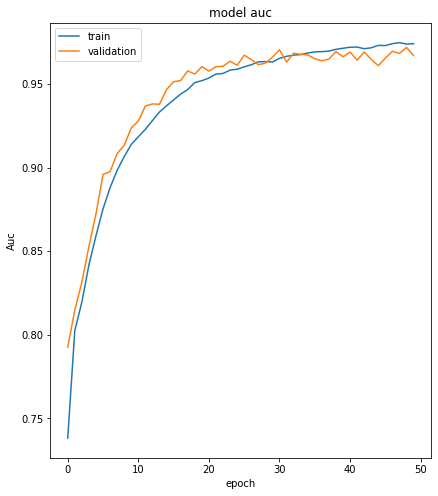

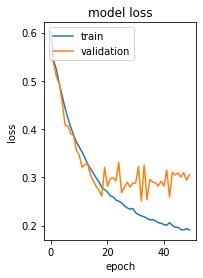

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.84212 \
From the diagram, the model learn better in the prevois trial without adding dropout and use_inter_layer_layernorm laye.

### **Trial 5**

* In this trial I will use:
 * I will use **balanced** data
 * Preprocessing
   * **max_vocab = 450** , max_len = 100
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * **hidden_dim = 64**
            * **num_heads = 4**
            * **message_calculation_class = RGAT**
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.83 and 0.85

**RGAT (Relational Graph Attention Networks)**

The primary idea is to create a hybrid network by combining graph attention networks and relational graph networks. It uses a message-passing mechanism to compute graph states.

#### Preprocessing

In [ ]:
max_vocab = 450
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[7 4 2 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0]
edges
[[  0  18]
 [  1  25]
 [  2  22]
 [  3  10]
 [  3  12]
 [  3  17]
 [  4   9]
 [  4  13]
 [  5  10]
 [  5  14]
 [  6   7]
 [  6  22]
 [  7  25]
 [  8  25]
 [  8  26]
 [  9  10]
 [  9  11]
 [ 11  12]
 [ 11  15]
 [ 12  16]
 [ 13  14]
 [ 13  20]
 [ 14  21]
 [ 15  18]
 [ 16  19]
 [ 17  22]
 [ 18  19]
 [ 20  23]
 [ 21  24]
 [ 23  24]
 [ 26  27]
 [ 26  28]
 [ 27  29]
 [ 28  30]
 [ 29  31]
 [ 30  31]
 [ 58  81]
 [ 58  88]
 [ 59  69]
 [ 59  85]
 [ 60  73]
 [ 60  83]
 [ 61  72]
 [ 61  86]
 [ 62  80]
 [ 63  83]
 [ 63  89]


#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyperparameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_heads"] = 4
params['message_calculation_class'] = 'RGAT'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

2530/2530 [==============================] - 100s 37ms/step - loss: 0.6156 - auc: 0.7239 - val_loss: 0.5888 - val_auc: 0.7697
Epoch 2/50
2530/2530 [==============================] - 98s 39ms/step - loss: 0.5751 - auc: 0.7744 - val_loss: 0.5881 - val_auc: 0.7826
Epoch 3/50
2530/2530 [==============================] - 101s 40ms/step - loss: 0.5542 - auc: 0.7934 - val_loss: 0.5734 - val_auc: 0.8069
Epoch 4/50
2530/2530 [==============================] - 98s 39ms/step - loss: 0.5334 - auc: 0.8126 - val_loss: 0.5082 - val_auc: 0.8319
Epoch 5/50
2530/2530 [==============================] - 96s 38ms/step - loss: 0.5064 - auc: 0.8336 - val_loss: 0.4964 - val_auc: 0.8451
Epoch 6/50
2530/2530 [==============================] - 96s 38ms/step - loss: 0.4936 - auc: 0.8440 - val_loss: 0.4933 - val_auc: 0.8497
Epoch 7/50
2530/2530 [==============================] - 97s 38ms/step - loss: 0.4834 - auc: 0.8504 - val_loss: 0.4703 - val_auc: 0.8602
Epoch 8/50
2530/2530 [==============================] - 1

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.921483  , 0.28057757, 0.03785754, ..., 0.08879419, 0.6029948 ,
       0.47279462], dtype=float32)

#### Display model

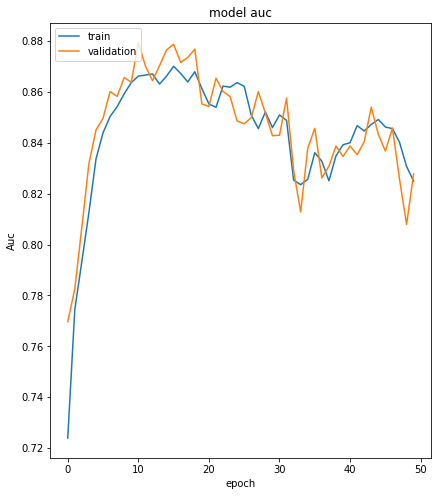

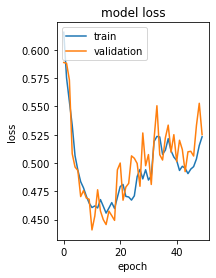

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.81428 \
From the diagram, RGAT may not be appropriate for this problem as the model begins to learn the data poorly, so in the next trial I will try to change preprocessing to improve the accuracy.

### **Trial 6**

* In this trial I will use:
 * I will use **balanced** data
 * Preprocessing
   * **max_vocab = 500** , max_len = 100
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * hidden_dim = 64
            * num_heads = 4
            * message_calculation_class = RGAT
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.81 and 0.82

**RGAT (Relational Graph Attention Networks)**

The primary idea is to create a hybrid network by combining graph attention networks and relational graph networks.It uses a message-passing mechanism to compute graph states.

#### Preprocessing

In [ ]:
max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
edges
[[  0  16]
 [  0  17]
 [  1  16]
 [  2  21]
 [  2  29]
 [  3  22]
 [  3  29]
 [  4  25]
 [  4  32]
 [  5  26]
 [  5  33]
 [  6  27]
 [  6  34]
 [  7  30]
 [  8  31]
 [  9  13]
 [  9  28]
 [ 10  11]
 [ 10  12]
 [ 10  16]
 [ 11  13]
 [ 11  17]
 [ 12  14]
 [ 18  12]
 [ 13  15]
 [ 14  15]
 [ 14  19]
 [ 15  20]
 [ 18  23]
 [ 18  24]
 [ 19  21]
 [ 20  22]
 [ 21  22]
 [ 23  25]
 [ 24  26]
 [ 25  27]
 [ 26  27]
 [ 28  30]
 [ 30  31]
 [ 42  52]
 [ 43  57]
 [ 44  59]
 [ 44  69]
 [ 45  59]
 [ 46  49]
 [ 46  50]
 [ 46  58]
 [ 47  48]
 [ 47  49]
 [ 47  51]
 [ 48  50]
 [ 48  53]
 [ 49  52]
 [ 50  56]
 [ 51  54]
 [ 51  63]
 [ 52  55]
 [ 53  57]
 [ 53  59

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyperparameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_heads"] = 4
params['message_calculation_class'] = 'RGAT'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

2530/2530 [==============================] - 98s 35ms/step - loss: 0.6183 - auc: 0.7193 - val_loss: 0.5932 - val_auc: 0.7518
Epoch 2/50
2530/2530 [==============================] - 88s 35ms/step - loss: 0.5731 - auc: 0.7734 - val_loss: 0.5487 - val_auc: 0.8091
Epoch 3/50
2530/2530 [==============================] - 89s 35ms/step - loss: 0.5379 - auc: 0.8082 - val_loss: 0.5331 - val_auc: 0.8239
Epoch 4/50
2530/2530 [==============================] - 88s 35ms/step - loss: 0.5105 - auc: 0.8317 - val_loss: 0.5314 - val_auc: 0.8274
Epoch 5/50
2530/2530 [==============================] - 87s 35ms/step - loss: 0.4913 - auc: 0.8460 - val_loss: 0.4893 - val_auc: 0.8563
Epoch 6/50
2530/2530 [==============================] - 87s 34ms/step - loss: 0.4750 - auc: 0.8571 - val_loss: 0.4799 - val_auc: 0.8607
Epoch 7/50
2530/2530 [==============================] - 86s 34ms/step - loss: 0.4685 - auc: 0.8611 - val_loss: 0.4739 - val_auc: 0.8631
Epoch 8/50
2530/2530 [==============================] - 88s

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.9713262 , 0.4989058 , 0.05719748, ..., 0.1403809 , 0.03529859,
       0.8718442 ], dtype=float32)

#### Display model

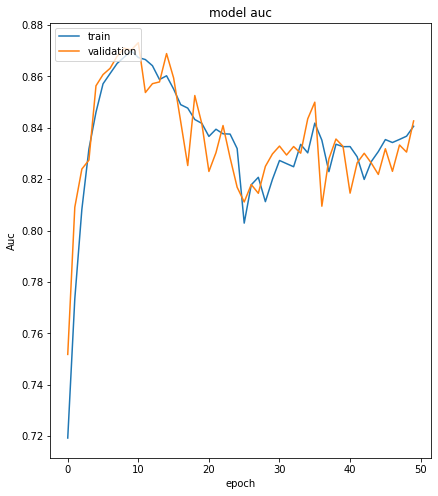

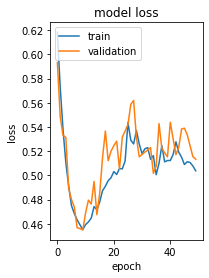

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.84084 \

From the diagram, the accuracy improve but I think the RGAT may not be appropriate for this problem as the model begins to learn the data poorly, so in the next trial I will try to add more layers to solve this problem and improve the accuracy.

### **Trial 7**

* In this trial I will use:
 * I will use **balanced** data
 * Preprocessing
   * **max_vocab = 500** , max_len = 100
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * hidden_dim = 64
            * num_heads = 4
            * **use_inter_layer_layernorm=False**
            * **layer_input_dropout_rate=0.3**
            * message_calculation_class = RGAT
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.84 and 0.85

**RGAT (Relational Graph Attention Networks)**

The primary idea is to create a hybrid network by combining graph attention networks and relational graph networks. It uses a message-passing mechanism to compute graph states.

#### Preprocessing

In [ ]:
max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 3
 3 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 3 3 3 3 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0   6]
 [  0  11]
 [  1  11]
 [  2  21]
 [  3  22]
 [  4  16]
 [  4  30]
 [  5  17]
 [  5  31]
 [  6   7]
 [  6   8]
 [  6   9]
 [  7  10]
 [  7  18]
 [  8  12]
 [  8  14]
 [  9  13]
 [  9  15]
 [ 10  11]
 [ 10  23]
 [ 12  16]
 [ 12  24]
 [ 13  17]
 [ 13  25]
 [ 14  19]
 [ 15  20]
 [ 16  21]
 [ 17  22]
 [ 18  26]
 [ 19  21]
 [ 19  32]
 [ 20  22]
 [ 20  33]
 [ 23  27]
 [ 24  28]
 [ 25  29]
 [ 26  27]
 [ 28  30]
 [ 29  31]
 [ 34  40]
 [ 34  46]
 [ 35  40]
 [ 36  37]
 [ 36  40]
 [ 37  39]
 [ 38  39]
 [ 38  41]
 [ 38  42]
 [ 41  43]
 [ 42  44]
 [ 43  45]
 [ 44  45]
 [ 68  76]
 [ 69  70]
 [ 69  73]
 [ 69  74]
 [ 70  71]
 [ 70  75]
 [ 71  72]
 [ 71  78]
 [ 72  73]
 [ 72  79]
 [ 74  77]
 [ 75  76]
 [ 76  7

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyperparameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_heads"] = 4
params["use_inter_layer_layernorm"] = False
params["layer_input_dropout_rate"] = 0.3
params['message_calculation_class'] = 'RGAT'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

2530/2530 [==============================] - 101s 38ms/step - loss: 0.6215 - auc: 0.7148 - val_loss: 0.5960 - val_auc: 0.7489
Epoch 2/50
2530/2530 [==============================] - 94s 37ms/step - loss: 0.5877 - auc: 0.7580 - val_loss: 0.5749 - val_auc: 0.7797
Epoch 3/50
2530/2530 [==============================] - 95s 37ms/step - loss: 0.5668 - auc: 0.7816 - val_loss: 0.5490 - val_auc: 0.7971
Epoch 4/50
2530/2530 [==============================] - 94s 37ms/step - loss: 0.5501 - auc: 0.7971 - val_loss: 0.5360 - val_auc: 0.8126
Epoch 5/50
2530/2530 [==============================] - 96s 38ms/step - loss: 0.5358 - auc: 0.8101 - val_loss: 0.5346 - val_auc: 0.8157
Epoch 6/50
2530/2530 [==============================] - 97s 38ms/step - loss: 0.5219 - auc: 0.8217 - val_loss: 0.5040 - val_auc: 0.8394
Epoch 7/50
2530/2530 [==============================] - 95s 37ms/step - loss: 0.5093 - auc: 0.8321 - val_loss: 0.4890 - val_auc: 0.8493
Epoch 8/50
2530/2530 [==============================] - 94

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([9.8080945e-01, 9.0762305e-01, 7.6276110e-04, ..., 4.8839222e-03,
       3.7714195e-01, 9.0093231e-01], dtype=float32)

#### Display model

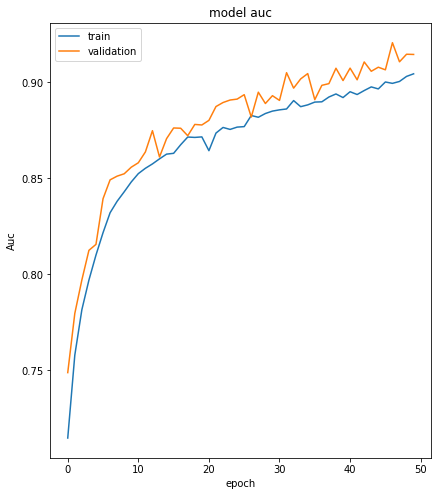

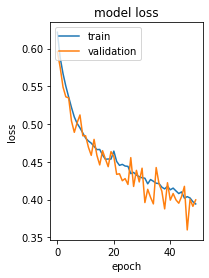

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.8567 \
From the diagram, the model learn better than last trials and the overfitting is very reduce and the accuracy very improved. In the next trial I will try different model.

### **Trial 8**

* In this trial I will use:
 * I will use **balanced** data
 * Preprocessing
   * **max_vocab = 500** , max_len = 100
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * **hidden_dim = 64**
            * **num_heads = 4**
            * **num_aggr_MLP_hidden_layers = 4**
            * **message_calculation_class = RGCN**
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.85 and 0.86

**RGCN (Relational Graph convolution layers)**
Used to semi-supervised node classification on (directed) relational graphs.
It's used to model relational data, particularly for tasks like link prediction and entity classification.It is use message passing mechanism to compute graph states 

#### Preprocessing

In [ ]:
max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[5 2 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 5 5 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0  25]
 [  1  13]
 [  1  26]
 [  2  12]
 [  3  16]
 [  3  27]
 [  4  19]
 [  4  28]
 [  5  11]
 [  5  12]
 [  5  18]
 [  6   8]
 [  6   9]
 [  7  23]
 [  7  29]
 [  7  30]
 [  8  10]
 [  8  13]
 [  9  12]
 [  9  15]
 [ 10  15]
 [ 10  20]
 [ 11  14]
 [ 11  21]
 [ 13  16]
 [ 14  17]
 [ 14  22]
 [ 16  19]
 [ 17  18]
 [ 17  25]
 [ 19  20]
 [ 21  23]
 [ 22  24]
 [ 23  24]
 [ 41  52]
 [ 41  59]
 [ 42  54]
 [ 43  56]
 [ 44  58]
 [ 45  64]
 [ 45  76]
 [ 46  60]
 [ 47  65]
 [ 48  66]
 [ 49  68]
 [ 50  53]
 [ 50  54]
 [ 50  56]
 [ 51  52]
 [ 51  54]
 [ 51  61]
 [ 52  55]
 [ 53  57]
 [ 53  67]
 [ 55  56]
 [ 55  65]
 [ 57  58]
 [ 57  60]
 [ 58  62]
 [ 59 

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyperparameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_heads"] = 4
params["num_aggr_MLP_hidden_layers"] = 4
params['message_calculation_class'] = 'RGAT'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgat_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memo

2530/2530 [==============================] - 97s 36ms/step - loss: 0.6181 - auc: 0.7186 - val_loss: 0.5973 - val_auc: 0.7502
Epoch 2/50
2530/2530 [==============================] - 98s 39ms/step - loss: 0.5776 - auc: 0.7695 - val_loss: 0.5578 - val_auc: 0.7985
Epoch 3/50
2530/2530 [==============================] - 88s 35ms/step - loss: 0.5387 - auc: 0.8085 - val_loss: 0.5163 - val_auc: 0.8272
Epoch 4/50
2530/2530 [==============================] - 88s 35ms/step - loss: 0.5146 - auc: 0.8284 - val_loss: 0.5224 - val_auc: 0.8235
Epoch 5/50
2530/2530 [==============================] - 87s 35ms/step - loss: 0.5033 - auc: 0.8366 - val_loss: 0.5072 - val_auc: 0.8394
Epoch 6/50
2530/2530 [==============================] - 88s 35ms/step - loss: 0.4880 - auc: 0.8478 - val_loss: 0.4820 - val_auc: 0.8551
Epoch 7/50
2530/2530 [==============================] - 89s 35ms/step - loss: 0.4812 - auc: 0.8526 - val_loss: 0.4821 - val_auc: 0.8564
Epoch 8/50
2530/2530 [==============================] - 88s

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.9548855 , 0.42775914, 0.06814345, ..., 0.08562993, 0.06014061,
       0.66272175], dtype=float32)

#### Display model

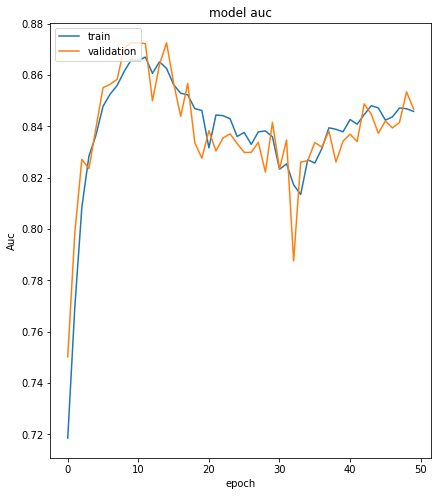

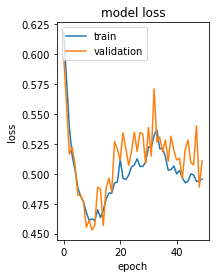

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.83131 \
From the diagram, the accuracy reduced and the model begins to learn the data poorly, so in the next trial I will try to add more layers to solve this problem and improve the accuracy.

### **Trial 9**

* In this trial I will use:
 * I will use **balanced** data
 * Preprocessing
   * **max_vocab = 500** , max_len = 100
   * Prepare nodes, labels, and links
   * Tokenize and convert data into integer numbers
   * Padding to tokenize
   * Generate multiple batches
   * Embedding 
  * Model
   * Layers
      * I will use GNN as an input 
      * GNN layer
          * Hyper parameters
            * I will use default hyper parameters
            * **hidden_dim = 64**
            * **num_heads = 4**
            * **num_aggr_MLP_hidden_layers = 4**
            * **use_inter_layer_layernorm = False**
            * **layer_input_dropout_rate = 0.3**
            * **message_calculation_class = RGCN**
      * Average layer
      * Dense layer with sigmoid activation function
   * Compile the model using AUC curve
   * Fit the model using epoch = 50 and batch_size = 16
   * Predict the model

**My thoughts and observations :** The accuracy would be between 0.83 and 0.85

**RGCN (Relational Graph convolution layers)**
Used to semi-supervised node classification on (directed) relational graphs.
It's used to model relational data, particularly for tasks like link prediction and entity classification.It is use message passing mechanism to compute graph states 

#### Preprocessing

In [ ]:
max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
# we use tokenizer as the data contain letters that need to tokenize
tokenizer = Tokenizer(num_words=max_vocab)
# fit_on_texts used to updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(all_nodes)

In [ ]:

def prepare_single_batch(samples):
  # samples return 3 values nodes, labels, and links so we will take node only
    sample_nodes = [s[0] for s in samples]
    # texts_to_sequences used to transforms each text in texts to a sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # put padding to tokenizers
    sample_nodes = pad_sequences(sample_nodes, padding='post')

    # max_nodes_len to know the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]                           #shape: (num of samples, number of nodes)
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]        #s[1]: links, i*max_nodes_len: to start indexing from current node not from 0 again
    edges = [e for e in edges if len(e) > 0]                          #make sure all elements(edges) are non-zero
    # takes order of graph and multiply by max number of nodes
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]

    
    # put all nodes and edges with each other in 1D array
    all_nodes = np.reshape(sample_nodes, -1)      #concatenate nodes of all samples together
    all_edges = np.concatenate(edges)             #concatenate edges of all samples together (because edge is tuple, doesnt hae reshape, output is 2D)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


# gen_batch this function used to generate multiple batches by calling prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
# batch_size put on it the number of samples that i want to be in one batch
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():          #k: labels, v: values
        print(k)
        print(v)
        #print(len(v))
        pass
    print('label', train_batch[1])
    break



data
[2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 4 2
 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 2 2 2 2 2 2 2 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 2 2 3 3 3 3 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
edges
[[  0   8]
 [  1   2]
 [  1   7]
 [  3   4]
 [  3   5]
 [  3   9]
 [  4   6]
 [  4  10]
 [  5   7]
 [  5  11]
 [  6   8]
 [  6  12]
 [  7   8]
 [  9  13]
 [ 10  15]
 [ 11  14]
 [ 12  16]
 [ 13  14]
 [ 15  16]
 [ 33  49]
 [ 34  52]
 [ 35  42]
 [ 35  43]
 [ 36  44]
 [ 37  47]
 [ 38  56]
 [ 38  59]
 [ 39  43]
 [ 39  44]
 [ 40  43]
 [ 40  48]
 [ 41  46]
 [ 41  47]
 [ 42  44]
 [ 42  45]
 [ 45  47]
 [ 46  49]
 [ 46  50]
 [ 48  53]
 [ 48  54]
 [ 49  51]
 [ 50  55]
 [ 51  52]
 [ 52  55]
 [ 53  57]
 [ 54  58]
 [ 56  57]
 [ 56  58]
 [ 59  60]
 [ 66  80]
 [ 66  82]
 [ 67  80]
 [ 68  85]
 [ 68  92]
 [ 69  86]
 [ 69  92]
 [ 70  89]
 [ 70  93]
 [ 71  90]
 [ 71  94]
 [ 72  91]
 [ 73  81]
 [ 74  75]
 [ 74  76]
 [ 74  79]
 [ 75

#### Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)     #edge is 2D
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data) # embedding data

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded, # nodes after embedding
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph, # number of samples
)
# Tuning hyperparameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_heads"] = 4
params["num_aggr_MLP_hidden_layers"] = 4
params["use_inter_layer_layernorm"] = False
params["layer_input_dropout_rate"] = 0.3
params['message_calculation_class'] = 'RGAT'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(  # Average layer (segment_mea is used to get the mean of elements in segments of a tensor)
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)        #binary classification: Dense(2), but here we only output 1 probability
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 16
# ceil function returns a ceiling value
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Training the model with batch size = 16 and epochs 50
history=model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

2530/2530 [==============================] - 101s 38ms/step - loss: 0.6234 - auc: 0.7132 - val_loss: 0.6165 - val_auc: 0.7382
Epoch 2/50
2530/2530 [==============================] - 93s 37ms/step - loss: 0.5936 - auc: 0.7526 - val_loss: 0.5698 - val_auc: 0.7822
Epoch 3/50
2530/2530 [==============================] - 95s 38ms/step - loss: 0.5672 - auc: 0.7813 - val_loss: 0.5586 - val_auc: 0.8036
Epoch 4/50
2530/2530 [==============================] - 94s 37ms/step - loss: 0.5460 - auc: 0.8016 - val_loss: 0.6143 - val_auc: 0.8054
Epoch 5/50
2530/2530 [==============================] - 95s 38ms/step - loss: 0.5308 - auc: 0.8146 - val_loss: 0.5178 - val_auc: 0.8303
Epoch 6/50
2530/2530 [==============================] - 95s 37ms/step - loss: 0.5165 - auc: 0.8262 - val_loss: 0.4914 - val_auc: 0.8476
Epoch 7/50
2530/2530 [==============================] - 94s 37ms/step - loss: 0.5071 - auc: 0.8341 - val_loss: 0.4933 - val_auc: 0.8454
Epoch 8/50
2530/2530 [==============================] - 96

In [ ]:
# predict function is used to enable us to predict the labels of the data values on the basis of the trained model.
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# repahe to get the first col only
y_pred = np.reshape(y_pred, -1)
y_pred.shape

(12326,)

In [ ]:
y_pred

array([0.9923234 , 0.76686823, 0.01889504, ..., 0.06489009, 0.4795255 ,
       0.4683265 ], dtype=float32)

#### Display model

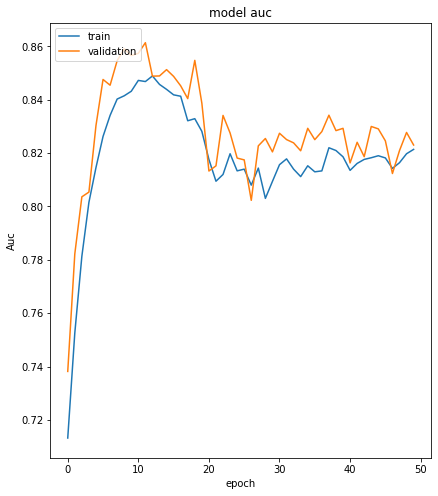

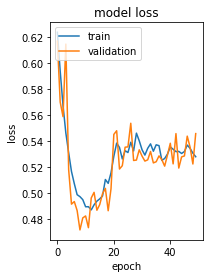

In [ ]:
# figure is used to create a new figure.
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc') # graph title
plt.ylabel('Auc') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/Queens_Practical/Data_Mining/compt6/sample_submission.csv')

#### Result

Accuracy in **kaggle** =0.82560 \
From the diagram, overfitting is increased, so the accuracy is reduced. The previous trial was better than this trial.

# **Questions**

**Based on the provided template, describe the format of the input file (sdf file).** \
* SDF files contain the molecular structures in plain text that associate data with one or more chemical structures. It is used to chemically compose a molecule. It contains nodes and their positions, and edges that connect them, as well as samples separated by the specific number of dolar signs.

* SDF consists of:-
    1. Data Header
     * Starts with the greater than character (>)
     * contains title or number of sample
    2. Data Value
     * composed of zero or more lines terminated by a blank line
    3. Grid Not Guaranteed
    4. Character Encoding

**What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**
* Nodes are a chemical compound that extracted and become as tokenize form by usong tokenizer then add padding to make all inputs have the same shape this by using pad_sequence function.
* The dims of each batch equal batch_size*max_len (batch_size is the number of samples in each batch , max_len is the size of tokenized nodes after padding)

**For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**
* gnn_out contains the size of the input data(nodes after embeding, edges, node2graph, and number of samples) and the aggregation mechanisms of the model.
* AVG is an average layer that uses the segmented_mean function to get the mean of elements in segments of a tensor to represent one sample with one number for each hidden layer. It's a method of gathering information for each sample and presenting it as mean data.

**What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**
* **segment_mean** computes the mean along sparse segments of a tensor that have the same segment
* **reduce_mean** computes the mean of elements across dimensions of a tensor.
* **pred** is an output that contains whether or not a chemical compound is active against cancer cells 

**What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**
* When I use multiple gcn layers, the complexity of the model will increase, so the model will learn more from the input data to predict an output close to the right (percentage) output but When I use one layer,this means the model may not be learning well, so the model will predict wrong most of the time.
* The number of layers that are used is 4.
